<a href="https://colab.research.google.com/github/GAKIZAB/Traitement-des-audios/blob/main/traitement_des_audios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Audio File Classification**

## **1. Introduction**

Audio file classification plays a pivotal role in modern technology, powering applications such as voice recognition, automatic translation, and voice-controlled systems. This project focuses on leveraging a 2D Convolutional Neural Network (CNN) to classify voice commands from the SPEECHCOMMANDS dataset, showcasing the power of deep learning in audio analysis.

The SPEECHCOMMANDS dataset comprises short audio recordings corresponding to voice commands like "backward," "bed," "left," and "right," along with their transcriptions. Each audio file undergoes preprocessing to produce a Mel spectrogram, a time-frequency representation of the audio signal. This transformation is particularly effective for CNN-based analysis, as spectrograms share structural similarities with images, enabling convolutional layers to extract meaningful patterns.

The primary objective of this project is to design and implement a high-accuracy 2D CNN model for voice command classification. Key steps include:
- **Audio Preprocessing:** Using the Torchaudio library to generate Mel spectrograms from raw audio files.
- **Model Design:** Developing a 2D CNN architecture tailored to the unique characteristics of spectrogram data.
- **Model Training and Evaluation:** Training the network on the SPEECHCOMMANDS dataset and assessing its performance.
- **Performance Analysis and Optimization:** Conducting detailed evaluations to refine the model and maximize classification accuracy.


## *Importing Packages*


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio.transforms as transforms
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
import matplotlib.pyplot as plt
import torchaudio
import numpy as np
import torchaudio

## *Loading Subsets of the SPEECHCOMMANDS Dataset*

In [2]:
# Loading the Datasets
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

# Load the subsets
train_set = SubsetSC("training")
validation_set = SubsetSC("validation")
test_set = SubsetSC("testing")


100%|██████████| 2.26G/2.26G [00:33<00:00, 72.3MB/s]


# **2. Data Exploration**

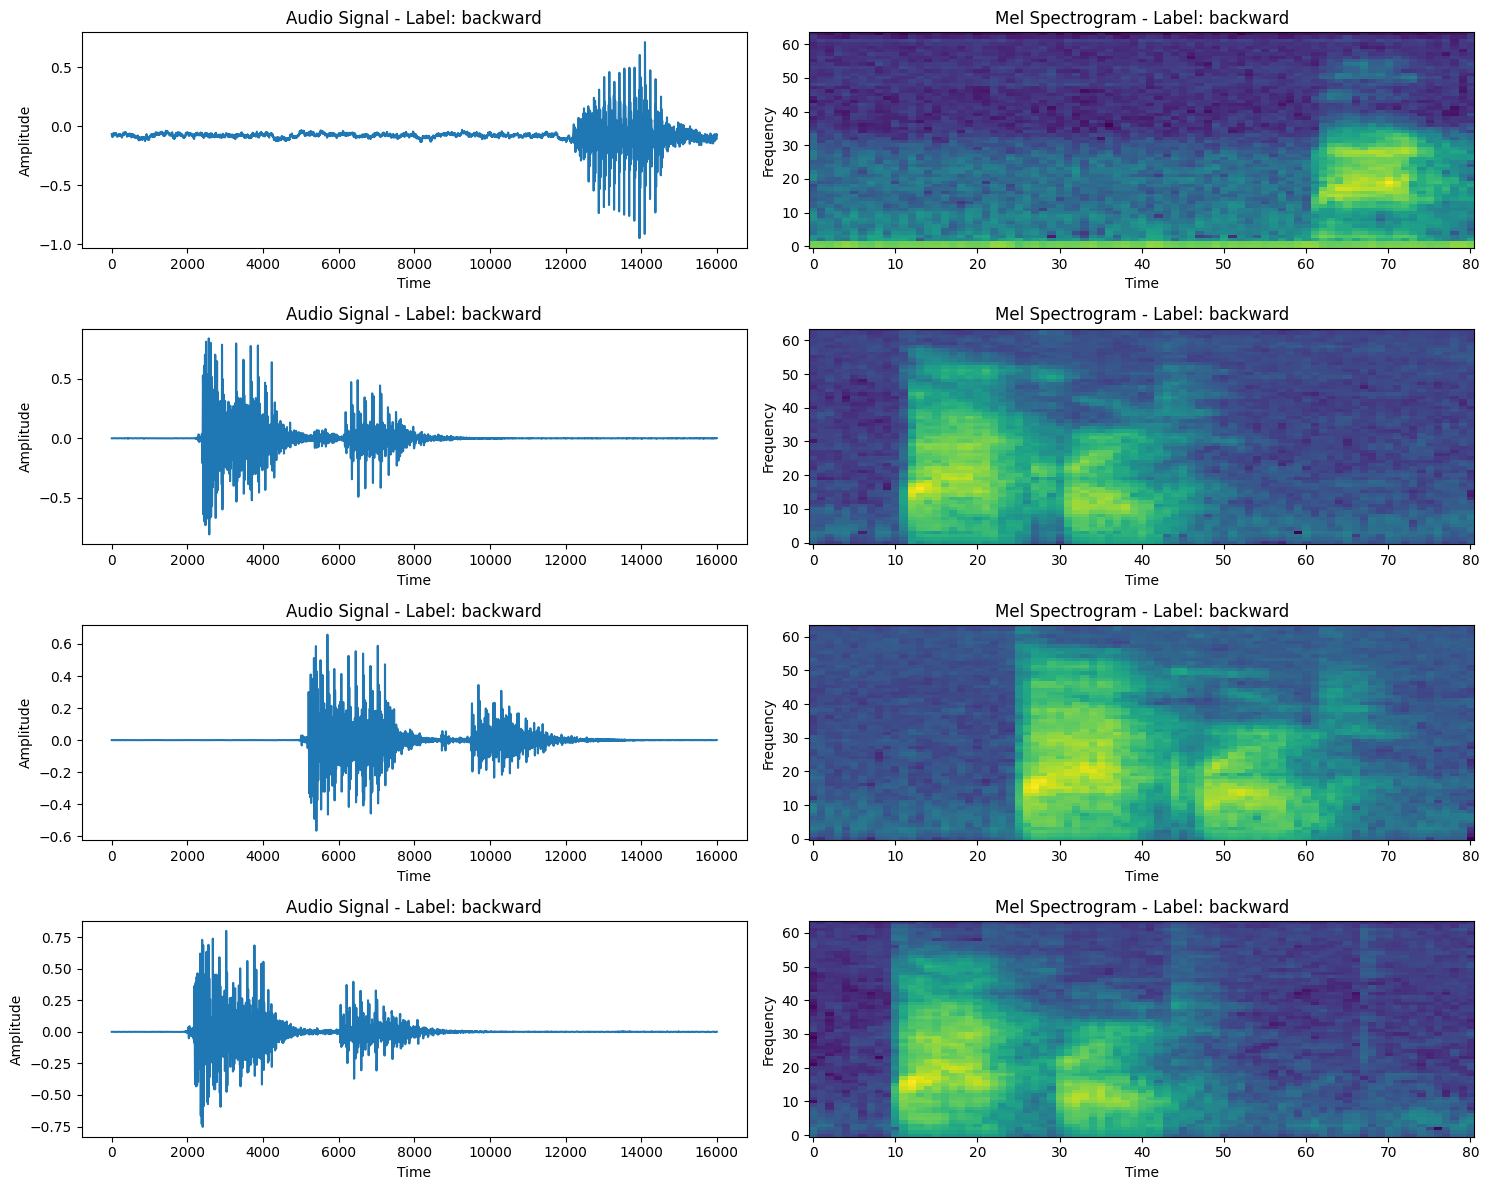

In [3]:
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as transforms

# Function to plot a signal and its spectrogram
def plot_signal_and_spectrogram(waveform, sample_rate, label, ax_signal, ax_spectrogram):
    # Plot the audio signal
    ax_signal.plot(waveform.t().numpy())
    ax_signal.set_title(f"Audio Signal - Label: {label}")
    ax_signal.set_xlabel("Time")
    ax_signal.set_ylabel("Amplitude")

    # Compute and plot the Mel spectrogram
    mel_spectrogram = transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=64)(waveform)
    ax_spectrogram.imshow(
        mel_spectrogram.log2()[0].detach().numpy(),
        aspect='auto',
        origin='lower',
        cmap='viridis'
    )
    ax_spectrogram.set_title(f"Mel Spectrogram - Label: {label}")
    ax_spectrogram.set_xlabel("Time")
    ax_spectrogram.set_ylabel("Frequency")

# Load 4 signal examples from the dataset
examples = [train_set[i] for i in range(4)]

# Create a figure to display the signals and their spectrograms
fig, axes = plt.subplots(4, 2, figsize=(15, 12))

for i, (waveform, sample_rate, label, *_ ) in enumerate(examples):
    plot_signal_and_spectrogram(
        waveform,
        sample_rate,
        label,
        axes[i, 0],  # Axis for the signal
        axes[i, 1]   # Axis for the spectrogram
    )

# Adjust spacing between plots
plt.tight_layout()
plt.show()


In [18]:
from IPython.display import Audio, display

# Listen to audio files
def play_audio(waveforms, sample_rate=16000):
    for i, waveform in enumerate(waveforms):
        print(f"Playing audio {i+1}")
        display(Audio(waveform.numpy(), rate=sample_rate))

# Play the 4 selected audio files
play_audio(waveforms)


Playing audio 1


Playing audio 2


Playing audio 3


Playing audio 4


In [4]:
from collections import Counter

def analyze_classes(dataset):
    print(f"Total number of samples: {len(dataset)}")

    # Counting the classes (labels)
    labels = [label for _, _, label, _, _ in dataset]
    label_counts = Counter(labels)

    print("\nDistribution of samples per class:")
    for label, count in label_counts.items():
        print(f"  {label}: {count} samples")

    return label_counts

# Call for the train_set
label_counts = analyze_classes(train_set)




Nombre total d'échantillons : 84843

Répartition des échantillons par classe :
  backward: 1346 échantillons
  bed: 1594 échantillons
  bird: 1697 échantillons
  cat: 1657 échantillons
  dog: 1711 échantillons
  down: 3134 échantillons
  eight: 3033 échantillons
  five: 3240 échantillons
  follow: 1275 échantillons
  forward: 1256 échantillons
  four: 2955 échantillons
  go: 3106 échantillons
  happy: 1632 échantillons
  house: 1727 échantillons
  learn: 1286 échantillons
  left: 3037 échantillons
  marvin: 1710 échantillons
  nine: 3170 échantillons
  no: 3130 échantillons
  off: 2970 échantillons
  on: 3086 échantillons
  one: 3140 échantillons
  right: 3019 échantillons
  seven: 3205 échantillons
  sheila: 1606 échantillons
  six: 3088 échantillons
  stop: 3111 échantillons
  three: 2966 échantillons
  tree: 1407 échantillons
  two: 3111 échantillons
  up: 2948 échantillons
  visual: 1288 échantillons
  wow: 1724 échantillons
  yes: 3228 échantillons
  zero: 3250 échantillons


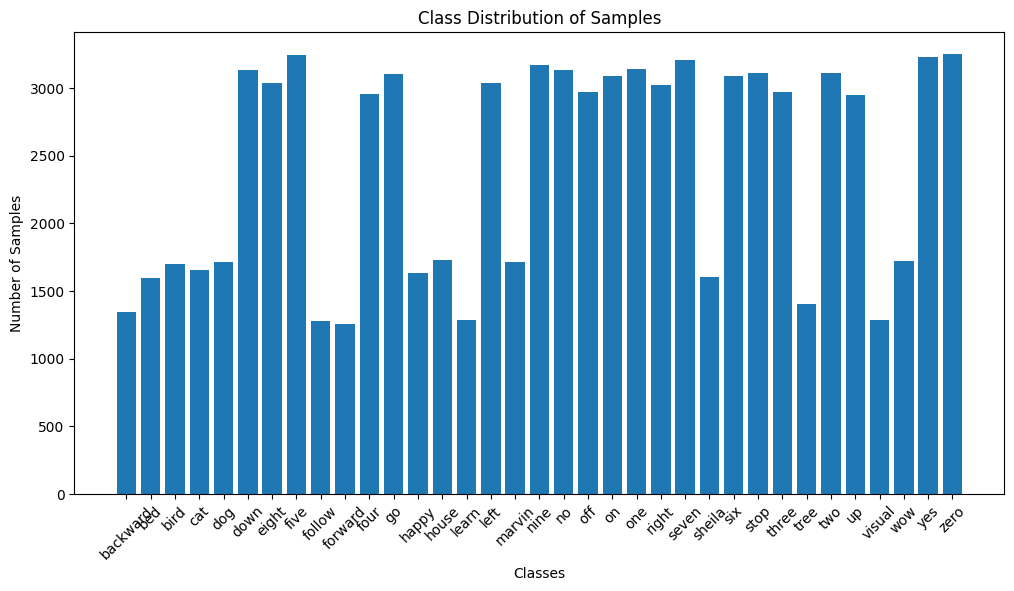

In [14]:
def plot_class_distribution(label_counts):
    # Display the class distribution
    plt.figure(figsize=(12, 6))
    plt.bar(label_counts.keys(), label_counts.values())
    plt.title("Class Distribution of Samples")
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.show()


# Call to display the data
plot_class_distribution(label_counts)



Durée moyenne des fichiers audio : 0.98 secondes
Durée maximale : 1.00 secondes
Durée minimale : 0.26 secondes


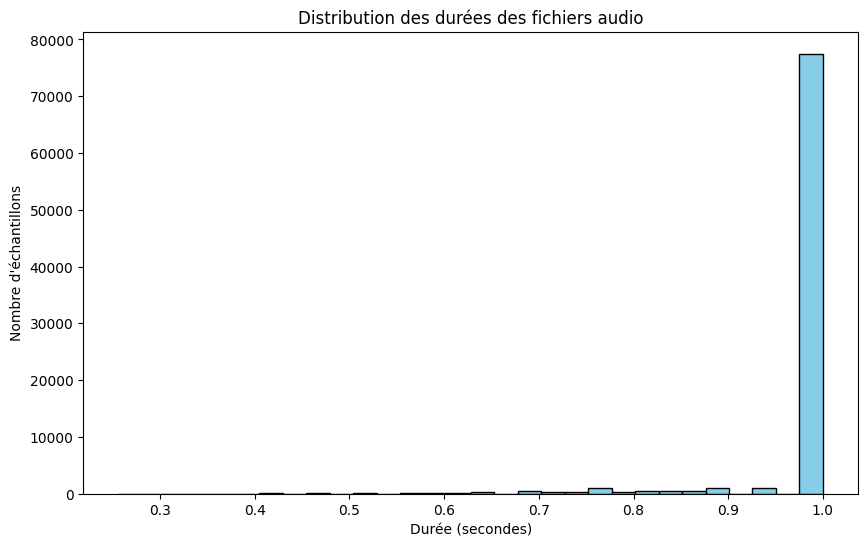

In [6]:
def analyze_durations(dataset):
    durations = [waveform.size(1) / sample_rate for waveform, sample_rate, _, _, _ in dataset]

    print(f"\nDurée moyenne des fichiers audio : {sum(durations)/len(durations):.2f} secondes")
    print(f"Durée maximale : {max(durations):.2f} secondes")
    print(f"Durée minimale : {min(durations):.2f} secondes")

    # Afficher la distribution des durées
    plt.figure(figsize=(10, 6))
    plt.hist(durations, bins=30, color='skyblue', edgecolor='black')
    plt.title("Distribution des durées des fichiers audio")
    plt.xlabel("Durée (secondes)")
    plt.ylabel("Nombre d'échantillons")
    plt.show()

# Appel pour le train_set
analyze_durations(train_set)

# **3. Preprocessing and Transforming Audio Data**

Preprocessing and transforming audio data are critical steps in developing deep learning models, particularly for tasks involving audio signals. This process ensures that raw, often heterogeneous, data is standardized and ready for efficient processing. The steps include transforming audio waveforms into normalized Mel spectrograms and managing their variable lengths.

## **a. `AudioTransform` Class: Transformation and Normalization**
The `AudioTransform` class is designed to convert audio waveforms into Mel spectrograms, a time-frequency representation well-suited for deep learning.

1. **Initialization:**
   - Two primary transformations are defined during instantiation:
     - **MelSpectrogram:** Converts an audio waveform into a Mel spectrogram with the following parameters:
       - `sample_rate=16000`: Standard sampling rate for audio data.
       - `n_fft=2048`: Window size for the Fourier Transform.
       - `hop_length=512`: Step size between successive windows.
       - `n_mels=64`: Number of Mel frequency bands.
     - **AmplitudeToDB:** Converts amplitude values to decibels with a maximum threshold of 80 dB, enhancing the representation of sound intensity variations.

2. **`__call__` Method:**
   - Enables an instance of `AudioTransform` to be used as a function. When invoked:
     - It applies the Mel spectrogram transformation.
     - Converts the spectrogram to decibels.
     - Normalizes the data (mean-centering and scaling by the standard deviation). This normalization improves the model's convergence.

## **b. `pad_spectrogram` Function: Dimension Standardization**
Generated spectrograms can vary in length depending on the duration of audio files. The `pad_spectrogram` function ensures all spectrograms have uniform dimensions for compatibility with neural networks:
- **Short spectrograms:** Spectrograms shorter than `max_length` (default 128) are padded with zeros.
- **Long spectrograms:** Spectrograms longer than `max_length` are truncated to keep only the first `max_length` points.

This step is essential for ensuring consistent batch processing during training.

## **c. `collate_fn` Function: Batch Preparation**
The `collate_fn` function organizes and prepares data for batch processing through the model. Key steps include:
1. **Transforming Waveforms:**
   - Audio waveforms in the batch are converted into normalized Mel spectrograms using an `AudioTransform` instance.

2. **Label Indexing:**
   - Text labels are mapped to numeric indices via a `label_to_index` dictionary.

3. **Dimension Management:**
   - Each spectrogram is passed through `pad_spectrogram` to standardize their lengths.

4. **Batch Creation:**
   - Spectrograms are stacked into a PyTorch tensor to form a batch. Labels are also converted into a tensor.



In [7]:
# Data Transformation and Management
class AudioTransform:
    def __init__(self):
        self.mel_spectrogram = transforms.MelSpectrogram(
            sample_rate=16000, n_fft=2048, hop_length=512, n_mels=64
        )
        self.db_transform = transforms.AmplitudeToDB(top_db=80)

    def __call__(self, waveform):
        mel = self.mel_spectrogram(waveform)
        db_mel = self.db_transform(mel)
        return (db_mel - db_mel.mean()) / db_mel.std()

def pad_spectrogram(spectrogram, max_length=128):
    if spectrogram.size(2) < max_length:
        pad_size = max_length - spectrogram.size(2)
        spectrogram = torch.nn.functional.pad(spectrogram, (0, pad_size))
    elif spectrogram.size(2) > max_length:
        spectrogram = spectrogram[:, :, :max_length]
    return spectrogram

def collate_fn(batch):
    transform = AudioTransform()
    waveforms, labels = zip(*[(transform(waveform), label_to_index[label]) for waveform, _, label, _, _ in batch])
    waveforms = [pad_spectrogram(waveform) for waveform in waveforms]
    waveforms = torch.stack(waveforms)
    labels = torch.tensor(labels)
    return waveforms, labels

# **3. Design of the 2D CNN Model**

The 2D CNN model outlined here is purpose-built for classifying Mel spectrograms, leveraging the power of deep learning to extract and interpret meaningful features from time-frequency representations. This architecture integrates convolutional layers, pooling operations, and fully connected layers, balancing high performance with computational efficiency.

### **Model Architecture**

1. **Convolutional Layers:**
   - The model consists of three convolutional layers that progressively extract more complex and abstract features from the input spectrograms:
     - **conv1 (1 → 32 filters):** The first layer processes the input with a single channel (normalized Mel spectrogram).
     - **conv2 (32 → 64 filters)** and **conv3 (64 → 128 filters):** Subsequent layers increase the filter count to detect intricate patterns and hierarchical features.

   The **progressive filter increase** (32 → 64 → 128) enables the model to learn representations ranging from simple edges to advanced, high-level patterns.

   - Each convolutional layer uses a **3x3 kernel** with **padding of 1**, which ensures spatial dimensions are preserved, allowing the network to capture local structures efficiently without excessive computational overhead.

   The **3x3 kernel size** is a widely adopted standard that strikes a balance between spatial resolution and computational demand.

2. **Pooling Layers:**
   - **2x2 MaxPooling** is applied after each convolutional layer, halving the feature map dimensions:
     - This reduces computational complexity, eliminates redundant information, and emphasizes the most significant features for subsequent layers.

3. **Dropout Layer:**
   - A **dropout layer** with a rate of **0.5** is incorporated before the fully connected layers to combat overfitting, especially crucial for limited datasets like voice command spectrograms.

4. **Fully Connected Layers:**
   - The feature maps produced by the convolutional layers are flattened into a vector using the `view` method.
   - **fc1 (128x8x16 → 256):** This fully connected layer consolidates the extracted features, reducing dimensionality.
   - **fc2 (256 → num_classes):** The final layer outputs class scores corresponding to the voice commands.

5. **Activation Functions:**
   - The **ReLU (Rectified Linear Unit)** activation function is used in all intermediate layers due to its efficiency and ability to support deep learning by mitigating vanishing gradient problems.


In [8]:
# Modèle CNN2D
class AudioCNN2D(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN2D, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        self.flatten_size = 128 * 8 * 16
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# **4. Training, Evaluation, and Testing**

In [9]:
# Entraînement et évaluation
def train(model, train_loader, validation_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    training_loss = []
    validation_loss = []
    training_acc = []
    validation_acc = []

    best_val_loss = float('inf')
    epochs_without_improvement = 0
    patience = 3

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for waveforms, labels in train_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(waveforms)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        training_loss.append(avg_loss)
        training_acc.append(train_accuracy)

        val_loss, val_accuracy = validate(model, validation_loader, criterion, device)
        validation_loss.append(val_loss)
        validation_acc.append(val_accuracy)
        scheduler.step()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

    return training_loss, validation_loss, training_acc, validation_acc

def validate(model, validation_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for waveforms, labels in validation_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            outputs = model(waveforms)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(validation_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for waveforms, labels in test_loader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            outputs = model(waveforms)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Graphique des performances
def plot_training_curves(training_loss, validation_loss, training_acc, validation_acc):
    epochs = range(1, len(training_loss) + 1)

    plt.figure()
    plt.plot(epochs, training_loss, label="Training Loss")
    plt.plot(epochs, validation_loss, label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, training_acc, label="Training Accuracy")
    plt.plot(epochs, validation_acc, label="Validation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


In [11]:
# Main
labels = sorted(list(set(label for _, _, label, _, _ in train_set)))
label_to_index = {label: i for i, label in enumerate(labels)}

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioCNN2D(num_classes=len(labels)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_fn)



# **5. Model Results**

In [ ]:
# Train
training_loss, validation_loss, training_acc, validation_acc = train(model, train_loader, validation_loader, criterion, optimizer, scheduler, device, num_epochs=10)


Epoch [1/10], Loss: 1.0692, Accuracy: 68.17%, Validation Loss: 0.5074, Validation Accuracy: 85.25%
Epoch [2/10], Loss: 0.5552, Accuracy: 83.05%, Validation Loss: 0.3861, Validation Accuracy: 88.43%
Epoch [3/10], Loss: 0.4562, Accuracy: 86.01%, Validation Loss: 0.3292, Validation Accuracy: 89.98%
Epoch [4/10], Loss: 0.4007, Accuracy: 87.56%, Validation Loss: 0.3198, Validation Accuracy: 90.54%
Epoch [5/10], Loss: 0.3592, Accuracy: 88.84%, Validation Loss: 0.3135, Validation Accuracy: 90.61%
Epoch [6/10], Loss: 0.2507, Accuracy: 92.17%, Validation Loss: 0.2481, Validation Accuracy: 92.55%
Epoch [7/10], Loss: 0.2238, Accuracy: 92.91%, Validation Loss: 0.2464, Validation Accuracy: 92.58%
Epoch [8/10], Loss: 0.2117, Accuracy: 93.27%, Validation Loss: 0.2438, Validation Accuracy: 92.78%
Epoch [9/10], Loss: 0.2043, Accuracy: 93.53%, Validation Loss: 0.2428, Validation Accuracy: 92.75%
Epoch [10/10], Loss: 0.1946, Accuracy: 93.80%, Validation Loss: 0.2422, Validation Accuracy: 92.85%


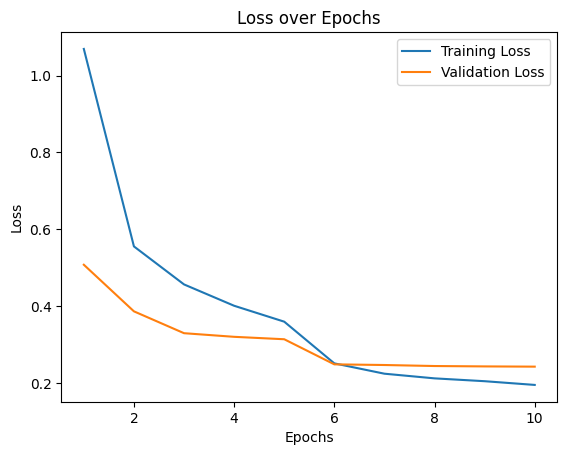

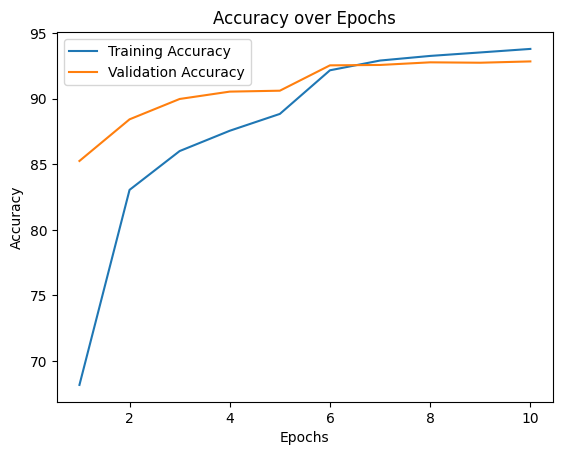

In [ ]:
# Performance Visualization
plot_training_curves(training_loss, validation_loss, training_acc, validation_acc)


### **Interpretation:**

1. **Loss:**  
   The training loss decreases steadily, indicating that the model is effectively learning to minimize error. The validation loss converges around 0.24, reflecting good generalization without any apparent signs of overfitting.

2. **Accuracy:**  
   The training accuracy reaches 93.8% after 10 epochs, while the validation accuracy stabilizes at 92.85%. The minimal gap between the two curves demonstrates a healthy balance between learning and generalization.

These results show that the model is converging properly and generalizes well to the validation data. The absence of overfitting, combined with the consistency between training and validation performance, suggests that the hyperparameters (such as learning rate and dropout) are well-tuned. This highlights the model's robustness and its potential for deployment on unseen data.

In [ ]:
# Model Testing
test_accuracy = test_model(model, test_loader, device)


Test Accuracy: 92.59%


**Interpretation:**

The model achieves an accuracy of 92.59% on the test dataset, reflecting strong generalization to unseen data. This high accuracy is consistent with the training and validation results, confirming the absence of overfitting. These findings demonstrate that the model is robust, well-tuned, and effectively designed for the task of voice command classification.